## Kan man forudsige hvor stort et problem bliver et sekund efter vi har konstateret det?
Ideen i denne KERAS model er at undersøge om man kan forudsige hvor stor en forstyrrelse i trafikken bliver et sekund efter at vi har konstaret problemet. 

I FED skriver driftslederen hvad der er sket i en kort tekst. Derefter begynder driftslederen at skrive en masse aktioner. Det er aflysninger, ændringer til hvordan trafikken skal køre osv. Problemets størrelse måler jeg her som antallet af aktioner (linjer) der skrives til overskriften. 

For simpelhedens skyld har jeg opdelt data i små og store problemer. Hvis der er op til 10 aktioner, så er det et "lille" problem. Hvis der 10 eller flere aktioner, så er det et "stort" priblem.

**Konklusionen** er længere nede, at en "machine learning" model kan lære at spotte problemets størrelse med meget stor sikkerhed (98%) blot ud fra overskriften.

Næste opgave bliver at arbejde med 
- "predictions" er ikke tæt nok på at være 0 eller 1, de er nærmere 0.1 og 0.5. Underligt ...
- Lave en model, som kan estimere antallet af aktioner ud fra overskriften
- Skifte fra "one hot" tekst-input til "embedding"
- prøve modellen med "validation_split=0.2"

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np

os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')
os.listdir()

['.ipynb_checkpoints', 'FEDData.xlsx', 'FED_01_FirstModel.ipynb']

Vi indlæser regnearket:

In [2]:
file = 'FEDData.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('RaaData_Forespørgsel')
print(xl.sheet_names)
print(df.shape)

['RaaData_Forespørgsel']
(26185, 4)


Vi lægger data over i to tabeller:

In [3]:
labels = df.loc[:,'FEDsize']
texts  = df.loc[:,'FEDtext']
FEDid  = df.loc[:,'FEDid']
labels = labels.values
texts  = texts.values
FEDid  = FEDid.values

for i in range(len(texts)):
    if not isinstance(texts[i],(str,)):
        print(i, texts[i])
print(FEDid)


[    1     2     3 ... 26183 26184 26185]


Vi laver en "one-hot" input vektor:

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som igen kan laves til en "one-hot)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# udfyld de tomme pladser med "0" og gem vores fulde input-datasæt i "data"
data = pad_sequences(sequences)

word_index = tokenizer.word_index

# lad os lige se hvad vi har lavet ind til nu
print('Found %s unique tokens.' % len(word_index))
print('Her er et eksempel:')
print(sequences[0])
print(texts[0])
print(labels[0])
print(data[0])

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 14290 unique tokens.
Her er et eksempel:
[286, 4, 6, 34, 1057, 116, 94]
PT er der ingen kørestrøm Ok-HG
1
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  286    4    6   34 1057  116   94]


Her prøver jeg lige at dekode teksten ingen:

In [5]:
# Vi vender word-index om, så vi kan omsætte retur til forståelig tekst
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i, '?') for i in data[0]])
print(decoded_review) 

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? pt er der ingen kørestrøm ok hg


Labels skal også over i et Numpy array, og lad os se formen:

In [6]:
labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (26185, 53)
Shape of label tensor: (26185,)


Nu "rafler" vi data, da de er sorteret med de største først i regnearket. Efterfølgende deles der op i data til træning, validering og test:

In [7]:
# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data   = data[indices]
labels = labels[indices]
FEDid  = FEDid[indices]

# halvdelen bruges til træning
training_samples = 15000
validation_samples = 5000
test_samples = 6000

x_train = data[:training_samples]
y_train = labels[:training_samples]
FEDid_train = FEDid[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
FEDid_val = FEDid[training_samples: training_samples + validation_samples]

x_test = data[training_samples + validation_samples: training_samples + validation_samples + test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples + test_samples]
FEDid_test = FEDid[training_samples + validation_samples: training_samples + validation_samples + test_samples]

print(x_train.shape)
print(y_train.shape)
print(FEDid_train.shape)
print(x_val.shape)
print(y_val.shape)
print(FEDid_val.shape)
print(x_test.shape)
print(y_test.shape)
print(FEDid_test.shape)

(15000, 53)
(15000,)
(15000,)
(5000, 53)
(5000,)
(5000,)
(6000, 53)
(6000,)
(6000,)


Lidt print for at forstå mine data ...

In [8]:
print(data[1])
print(labels[1:200])
print(FEDid_test)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 1834]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[ 4057  4173 20303 ...  5883  3165 15793]


Så skal vi lave input om til en "one-hot":

In [9]:
# funktion som lave one-hot vektorer
def vectorize_sequences(sequences, dimension=10000):
    # lave en all-zero matrix af formen (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# One-hot training data
x_train = vectorize_sequences(x_train, dimension=max_words)
# One-hot test data
x_val = vectorize_sequences(y_val, dimension=max_words)
# One-hot test data
x_test = vectorize_sequences(y_test, dimension=max_words)

print(x_train)
print(' ')
print(x_val)
print(' ')
print(x_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
 
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
 
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Vi skal også vektorisere vores labels:

In [10]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')
y_test = np.asarray(y_test).astype('float32')

Nu bygger vi modellen:

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Modellen oversættes og vi bruger følgende parametre:
    - Optimizer: rmsprop
    - Loss function: binary_crossentropy
    - Målemetode: Accuracy

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Træn modellen:

In [13]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 5000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 269us/step - loss: 0.5480 - acc: 0.9562 - val_loss: 0.5802 - val_acc: 0.9812
Epoch 2/20
15000/15000 [==============================] - 2s 133us/step - loss: 0.3288 - acc: 0.9804 - val_loss: 0.4802 - val_acc: 0.9812
Epoch 3/20
15000/15000 [==============================] - 2s 133us/step - loss: 0.2015 - acc: 0.9804 - val_loss: 0.3816 - val_acc: 0.9812
Epoch 4/20
15000/15000 [==============================] - 2s 133us/step - loss: 0.1388 - acc: 0.9804 - val_loss: 0.2935 - val_acc: 0.9812
Epoch 5/20
15000/15000 [==============================] - 2s 131us/step - loss: 0.1120 - acc: 0.9804 - val_loss: 0.2269 - val_acc: 0.9812
Epoch 6/20
15000/15000 [==============================] - 2s 128us/step - loss: 0.1003 - acc: 0.9804 - val_loss: 0.1916 - val_acc: 0.9812
Epoch 7/20
15000/15000 [==============================] - 2s 129us/step - loss: 0.0922 - acc: 0.9804 - val_loss: 0.1730 - v

Nu skal vi se hvordan læringen skrider frem. Vi henter lærings-historien ud af modellen:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Vi plotter læringen:

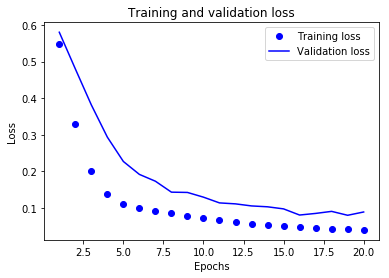

In [20]:
import matplotlib.pyplot as plt

accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs = range(1, len(history_dict['binary_accuracy']) + 1)
epochs = range(1, 21)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

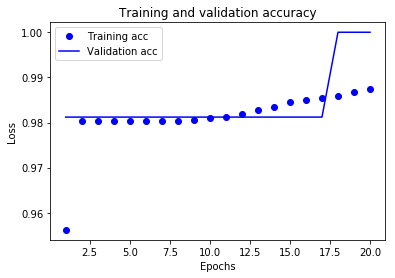

In [16]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Vi afprøver modellens styrke ved at teste den på nye data (test-data):

In [17]:
predictions = model.predict(x_test)
predictions[1:600]

array([[0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.07654829],
       [0.076

In [18]:
for i in range(1,6000):
    if predictions[i]>0.2:
        print(FEDid_test[i], predictions[i])


453 [0.5643828]
388 [0.5643828]
135 [0.5643828]
139 [0.5643828]
356 [0.5643828]
361 [0.5643828]
262 [0.5643828]
272 [0.5643828]
242 [0.5643828]
57 [0.5643828]
373 [0.5643828]
166 [0.5643828]
252 [0.5643828]
321 [0.5643828]
297 [0.5643828]
8 [0.5643828]
223 [0.5643828]
46 [0.5643828]
276 [0.5643828]
446 [0.5643828]
438 [0.5643828]
171 [0.5643828]
489 [0.5643828]
35 [0.5643828]
441 [0.5643828]
267 [0.5643828]
385 [0.5643828]
459 [0.5643828]
55 [0.5643828]
466 [0.5643828]
485 [0.5643828]
213 [0.5643828]
328 [0.5643828]
43 [0.5643828]
305 [0.5643828]
179 [0.5643828]
421 [0.5643828]
196 [0.5643828]
236 [0.5643828]
280 [0.5643828]
14 [0.5643828]
427 [0.5643828]
483 [0.5643828]
299 [0.5643828]
201 [0.5643828]
40 [0.5643828]
9 [0.5643828]
400 [0.5643828]
414 [0.5643828]
159 [0.5643828]
429 [0.5643828]
255 [0.5643828]
404 [0.5643828]
113 [0.5643828]
144 [0.5643828]
174 [0.5643828]
220 [0.5643828]
173 [0.5643828]
439 [0.5643828]
467 [0.5643828]
16 [0.5643828]
20 [0.5643828]
324 [0.5643828]
281 [

I test-sættet har modellen fundet linje 422 som værende "stor". JEg vil gerne se hvad den hændelse handler om. Derfor kikker jeg i "rafle-tabellen" og finder 422. 422 står i linje 13711, så teksten i den (opringede) linje finder jeg frem:

In [19]:
for i in range(0,24000):
    if indices[i] == 164:
        print(i)
        break
print(texts[indices[i]])
print('-'*40)


# her ville det nok være mere pythonic at lave en omvendt oversættelse ved at gøre noget i retningen af:
# reverse_line_index = dict([(value, key) for (key, value) in indices])
# decoded_line = ' '.join([reverse_line_index.get(i, '?') for i in texts[0]])

# reverse_line_index = [idx for idx in enumerate(indices, 1)]
# print(reverse_line_index)

print('Antal store i datasættet:    ', sum(y_test))

NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.2 and FEDid_test[i]<=493:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)

print('Modellens præcision:         ', round(NumEstimated/sum(y_test)*100), '%')



19589
nedformeringer fra og til Sverige.
----------------------------------------
Antal store i datasættet:     104.0
antal estimeret af modellen:  104
Modellens præcision:          100.0 %
